In [1]:
import numpy as np
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import optuna
import random
import joblib

results_dir = '../results/syntheticdata/variables=[0,2]'
images_dir = '../images/syntheticdata/variables=[0,2]'
data_dir = '../data/syntheticdata/variables=[0,2]'

In [2]:
import torch
from torch import nn
from utils.train_pipeline import EarlyStopper, ModelTrainingPipeline, run_optuna_study

seed = 1729

torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_per_process_memory_fraction(0.2, device=torch.device('cuda:0'))

early_stopper = EarlyStopper(patience=10, min_delta=1e-5, min_epochs=100)
pipeline = ModelTrainingPipeline(device=device, early_stopper=early_stopper)
pipeline.set_seed(seed)

x = torch.rand(5, 3)
print(x)

tensor([[0.3126, 0.3791, 0.3087],
        [0.0736, 0.4216, 0.0691],
        [0.2332, 0.4047, 0.2162],
        [0.9927, 0.4128, 0.5938],
        [0.6128, 0.1519, 0.0453]])


In [3]:
#load data 
n = 100000 #number of data points
k = 3 #number of variables
p = 5 # pattern length
variable_indexes = np.arange(k)
variables_pattern = [0,2]

dataset_path = os.path.join(data_dir, "scenario1_n={}_k={}_p={}_min_step={}_max_step={}_variables={}.csv".format(n, k, p, 5, 45, variables_pattern))
motif_indexes_path = os.path.join(data_dir, "motif_indexes_scenario1_n={}_k={}_p={}_min_step={}_max_step={}.csv".format(n, k, p, 5, 45))
data = np.genfromtxt(dataset_path, delimiter=",").astype(int).reshape((k, n))
motif_indexes = np.genfromtxt(motif_indexes_path, delimiter=",").astype(int)

print(motif_indexes)


[    0    10    22 ... 99922 99956 99992]


TRAIN: [    0     1     2 ... 15997 15998 15999] TEST: [16000 16001 16002 ... 19997 19998 19999]
TRAIN: [20000 20001 20002 ... 35997 35998 35999] TEST: [36000 36001 36002 ... 39997 39998 39999]
TRAIN: [40000 40001 40002 ... 55997 55998 55999] TEST: [56000 56001 56002 ... 59997 59998 59999]
TRAIN: [60000 60001 60002 ... 75997 75998 75999] TEST: [76000 76001 76002 ... 79997 79998 79999]
TRAIN: [80000 80001 80002 ... 95997 95998 95999] TEST: [96000 96001 96002 ... 99997 99998 99999]


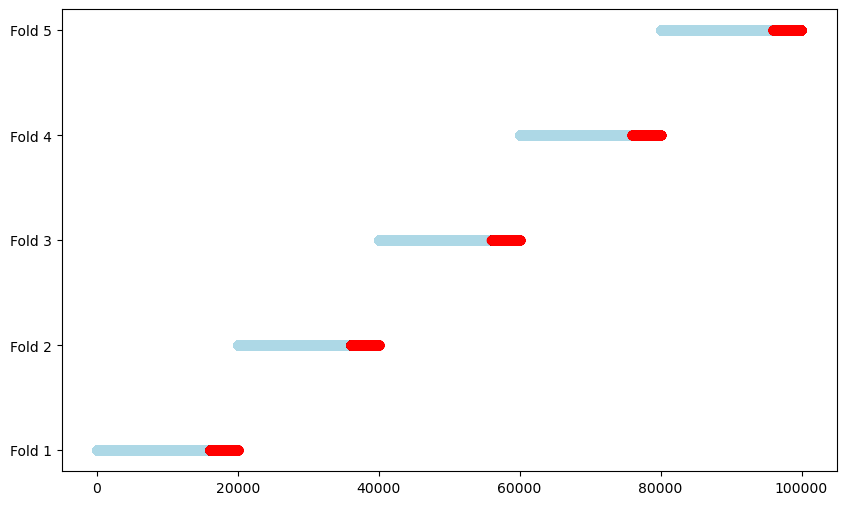

In [4]:
from utils.timeseries_split import BlockingTimeSeriesSplit

#create index  
indexes = np.arange(len(data[0]))

#split data
tscv = BlockingTimeSeriesSplit(n_splits=5)
# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))
for i, (train_index, test_index) in enumerate(tscv.split(indexes)):
    # Plot train and test indices
    ax.plot(train_index, np.zeros_like(train_index) + i, 'o', color='lightblue')
    ax.plot(test_index, np.zeros_like(test_index) + i, 'o', color='red')
    print("TRAIN:", train_index, "TEST:", test_index)
    

ax.set_yticks(np.arange(5), ["Fold {}".format(i) for i in range(1, 6)])
plt.show()

In [5]:
from utils.utils import create_dataset

lookback_period = 100 #window size
step = 5 #step size for the sliding window
forecast_period = 50 #forward window size

#x1: past window, x2: indexes of the motif in the window,  y: next relative index of the motif
X1, X2, y = create_dataset(data, variable_indexes, lookback_period, step, forecast_period, motif_indexes)

# X1, X2, and y are now PyTorch tensors
print("X1 shape:", X1.shape)  # Expected shape: (num_samples, lookback_period, num_features)
print("X2 shape:", X2.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
print("y shape:", y.shape)    # Expected shape: (num_samples, 1)


X1 shape: torch.Size([19979, 100, 3])
X2 shape: torch.Size([19979, 6])
y shape: torch.Size([19979, 1])


In [6]:
from models.lstm_pytorch import LSTMX1
from utils.utils import print_study_results, plot_best_model_results


n_trials = 100
num_epochs = 500
model_type = "LSTM"
model_name = "LSTMX1"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3], 
        "kwargs": {"log": True} 
    },
    "num_layers": {
        "type": "categorical",
        "args": [[1, 2, 3, 4, 5]]  
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]] 
    }
}

model_params_keys = ["hidden_sizes_list"]


result_dir = os.path.join(results_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(result_dir, exist_ok=True)  

run_optuna_study(pipeline.run_cross_val, LSTMX1, model_type, suggestion_dict, model_params_keys, seed, X1, None, y, result_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(result_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(study.trials_dataframe(), save_path=os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))


[I 2024-12-12 19:11:39,480] A new study created in memory with name: no-name-19c61cd7-f56e-4932-8dac-02856bfe850d


Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499


[I 2024-12-12 19:19:55,345] Trial 0 finished with value: 185.58826599121093 and parameters: {'learning_rate': 2.6565450821928437e-05, 'num_layers': 5, 'batch_size': 64, 'hidden_size_layer_0': 32, 'hidden_size_layer_1': 32, 'hidden_size_layer_2': 32, 'hidden_size_layer_3': 128, 'hidden_size_layer_4': 16}. Best is trial 0 with value: 185.58826599121093.


Training completed all epochs. Best epoch was 499
Early stopping at epoch 111, with best epoch being 97
Early stopping at epoch 134, with best epoch being 39
Early stopping at epoch 123, with best epoch being 112
Early stopping at epoch 151, with best epoch being 140


[I 2024-12-12 19:20:38,992] Trial 1 finished with value: 140.3963623046875 and parameters: {'learning_rate': 0.0005201806287602701, 'num_layers': 2, 'batch_size': 128, 'hidden_size_layer_0': 32, 'hidden_size_layer_1': 64}. Best is trial 1 with value: 140.3963623046875.


Early stopping at epoch 125, with best epoch being 110
Early stopping at epoch 359, with best epoch being 348
Early stopping at epoch 280, with best epoch being 268
Early stopping at epoch 365, with best epoch being 354
Early stopping at epoch 344, with best epoch being 333


[I 2024-12-12 19:26:15,120] Trial 2 finished with value: 140.39752502441405 and parameters: {'learning_rate': 1.2453498033601551e-05, 'num_layers': 4, 'batch_size': 64, 'hidden_size_layer_0': 16, 'hidden_size_layer_1': 32, 'hidden_size_layer_2': 128, 'hidden_size_layer_3': 128}. Best is trial 1 with value: 140.3963623046875.


Early stopping at epoch 366, with best epoch being 354
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499


[I 2024-12-12 19:31:02,683] Trial 3 finished with value: 185.25643005371094 and parameters: {'learning_rate': 2.4396360123977827e-05, 'num_layers': 4, 'batch_size': 128, 'hidden_size_layer_0': 128, 'hidden_size_layer_1': 64, 'hidden_size_layer_2': 64, 'hidden_size_layer_3': 32}. Best is trial 1 with value: 140.3963623046875.


Training completed all epochs. Best epoch was 499
Early stopping at epoch 116, with best epoch being 105
Early stopping at epoch 111, with best epoch being 67


[W 2024-12-12 19:33:53,642] Trial 4 failed with parameters: {'learning_rate': 0.0009804052004436631, 'num_layers': 2, 'batch_size': 16, 'hidden_size_layer_0': 32, 'hidden_size_layer_1': 256} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/mgsilva/miniconda3/envs/torch_motifpredenv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/home/mgsilva/motifpred/code/utils/train_pipeline.py", line 82, in objective
  File "/home/mgsilva/motifpred/code/utils/train_pipeline.py", line 407, in run_cross_val
    model = model_class(input_channels=X1.shape[2] + 1, sequence_length=X1.shape[1], output_dim=1, **model_hyperparams).to(self.device)
                                                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mgsilva/motifpred/code/utils/train_pipeline.py", line 

KeyboardInterrupt: 

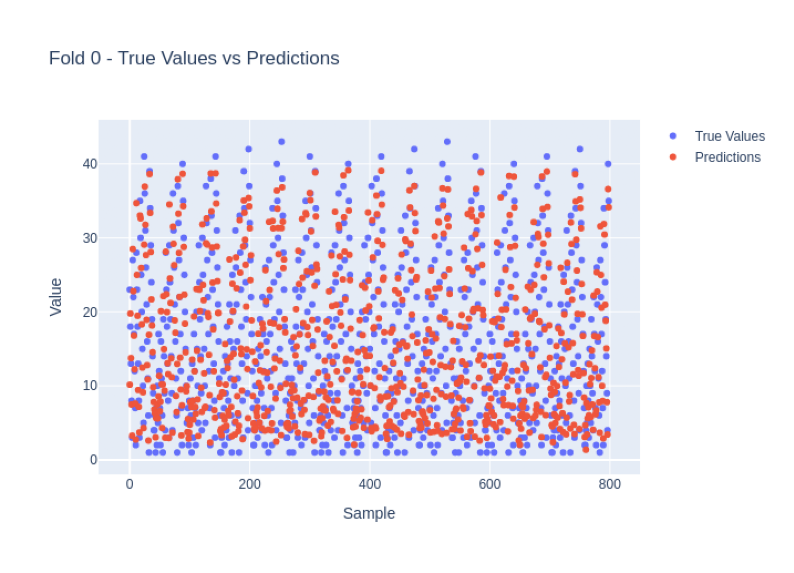

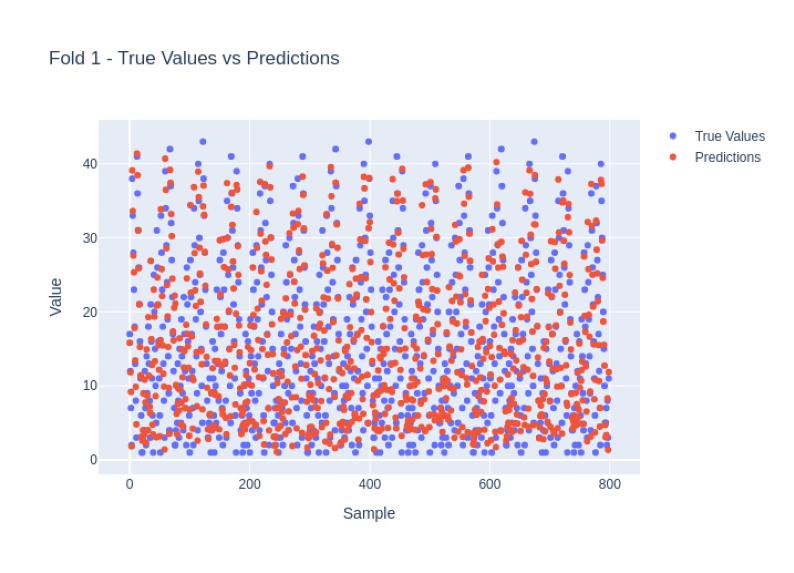

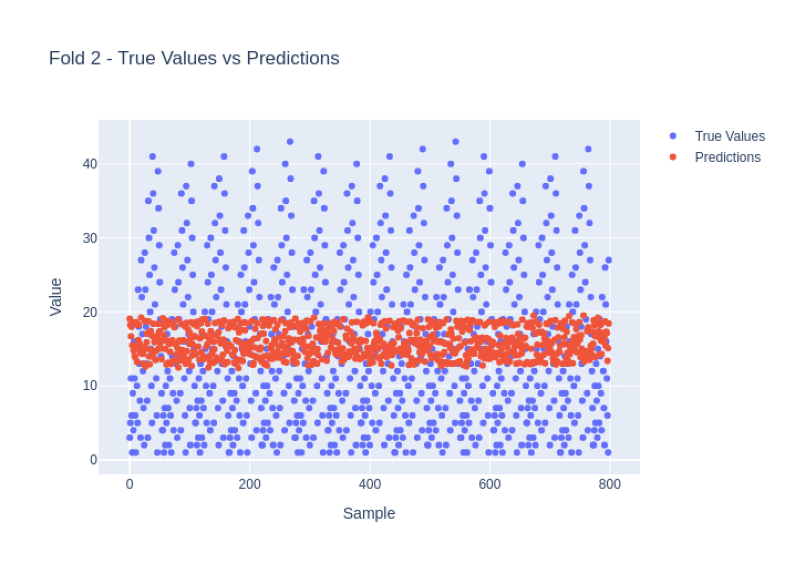

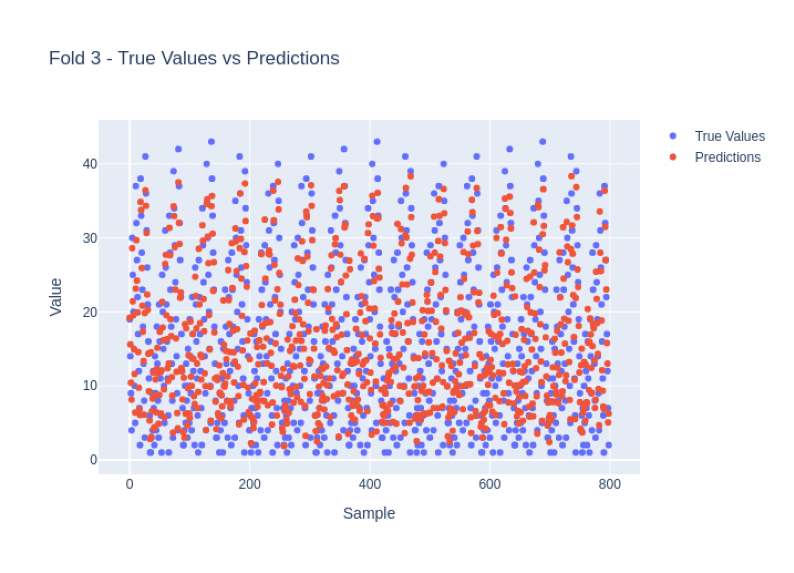

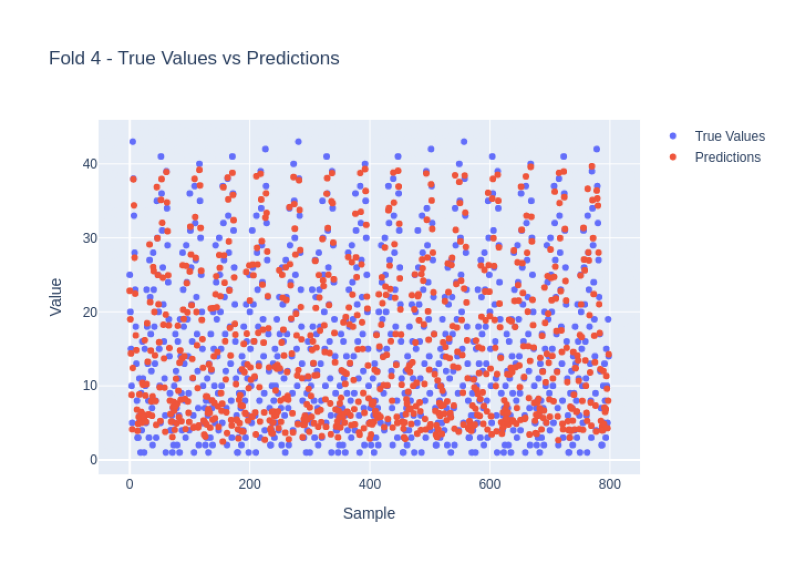

In [7]:
# from utils.utils import plot_preds_vs_truevalues
# from utils.train_pipeline import get_preds_best_config

# epochs_train_losses, epochs_val_losses, all_predictions, all_true_values = get_preds_best_config(study, pipeline, LSTMX1, model_type, model_params_keys, num_epochs = num_epochs, seed=seed, X1=X1, X2=None, y=y)

# # Plot the train and validation losses for each fold
# fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)
# for i in range(5):
#     axes[i].plot(epochs_train_losses[i], label="Train Loss")
#     axes[i].plot(epochs_val_losses[i], label="Validation Loss")
#     axes[i].set_title(f"Fold {i + 1}")
#     axes[i].set_xlabel("Epoch")
#     if i == 0:
#         axes[i].set_ylabel("Loss")
#     axes[i].legend()

# plt.tight_layout()
# plt.show()

# # Plot the predictions vs true values for each fold
# for fold in range(5):
#     plot_preds_vs_truevalues(np.ravel(all_true_values[fold]), np.ravel(all_predictions[fold]), fold, save_path=os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))

for fold in range(5):
    img = mpimg.imread(os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')  # Hide axes for a cleaner display
    plt.show()


Number of finished trials:  100
Best trial: 13
Best hyperparameters: {'learning_rate': 0.00014593541015426787, 'hidden_size': 128, 'num_layers': 3, 'batch_size': 16}
Validation Losses: [0.029, 0.016, 0.02, 0.019, 0.036]
Mean validation loss: 0.024
Test Losses: [0.312, 0.026, 13.478, 0.14, 0.104]
Mean test loss: 2.812
Mean test MAE: 0.384 std: 0.39
Mean test RMSE: 1.018 std: 1.333


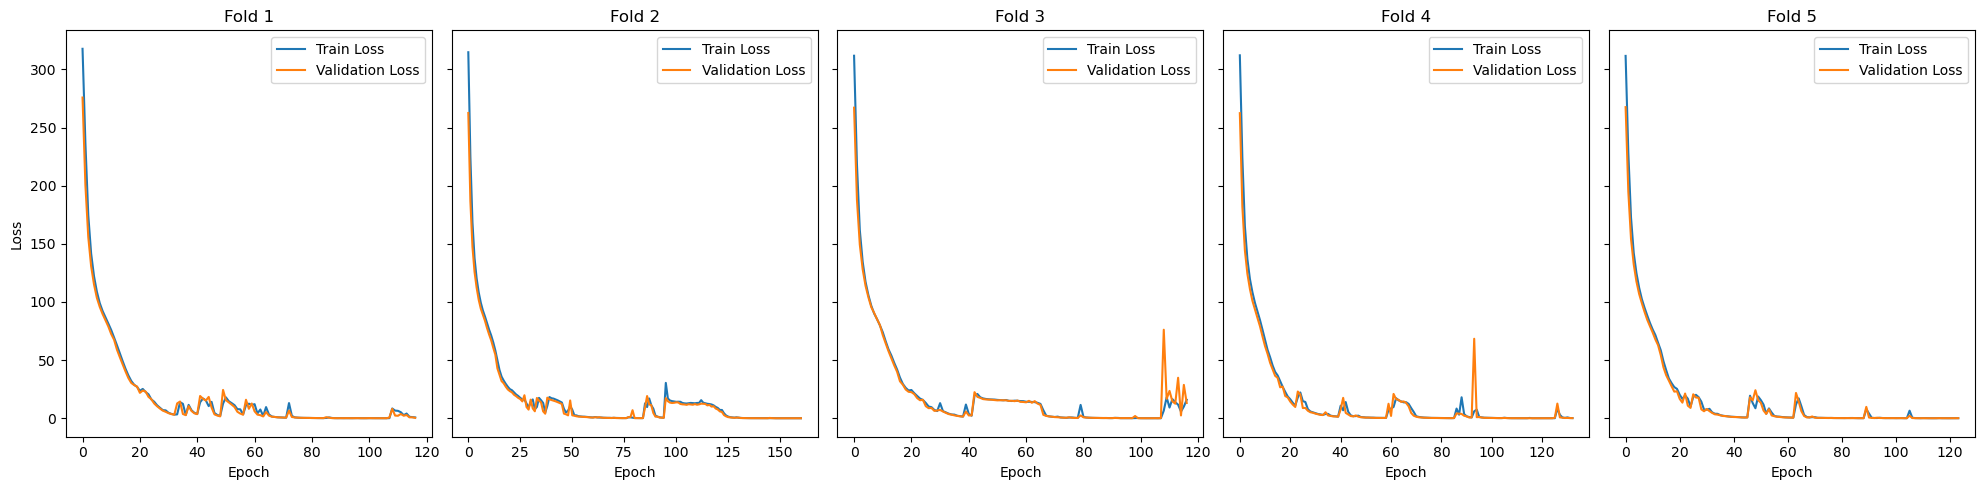

In [8]:
from models.lstm_pytorch import LSTMX1_X2BeforeLSTM
from utils.train_pipeline import EarlyStopper, ModelTrainingPipeline, run_optuna_study 

n_trials = 100
num_epochs = 500
model_type = "LSTM"
model_name = "LSTM_X1_X2BeforeLSTM"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3], 
        "kwargs": {"log": True} 
    },
    "hidden_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128, 256]] 
    },
    "num_layers": {
        "type": "categorical",
        "args": [[1, 2, 3]]  
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]] 
    }
}

model_params_keys = ["hidden_size", "num_layers"]

result_dir = os.path.join(results_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(result_dir, exist_ok=True)

#run_optuna_study(pipeline.run_cross_val, LSTMX1_X2BeforeLSTM, model_type, suggestion_dict, model_params_keys, seed, X1, X2, y, result_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(result_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(study.trials_dataframe(), save_path=os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))



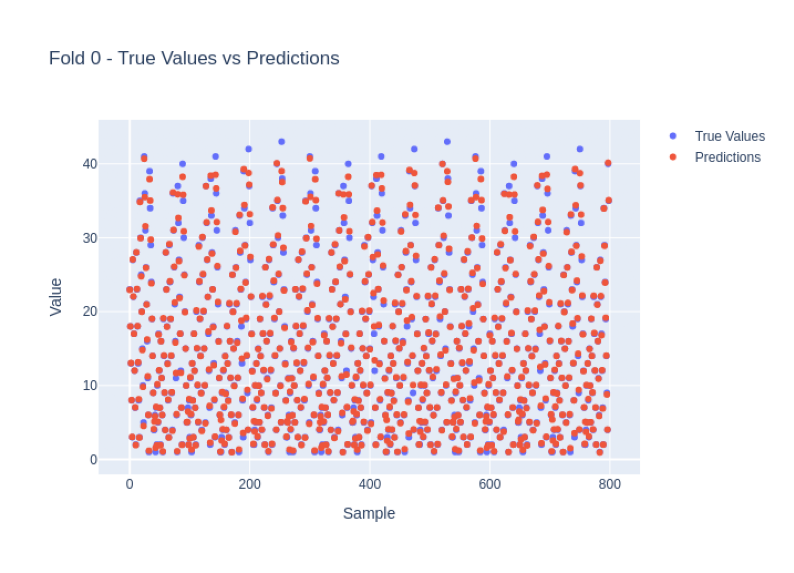

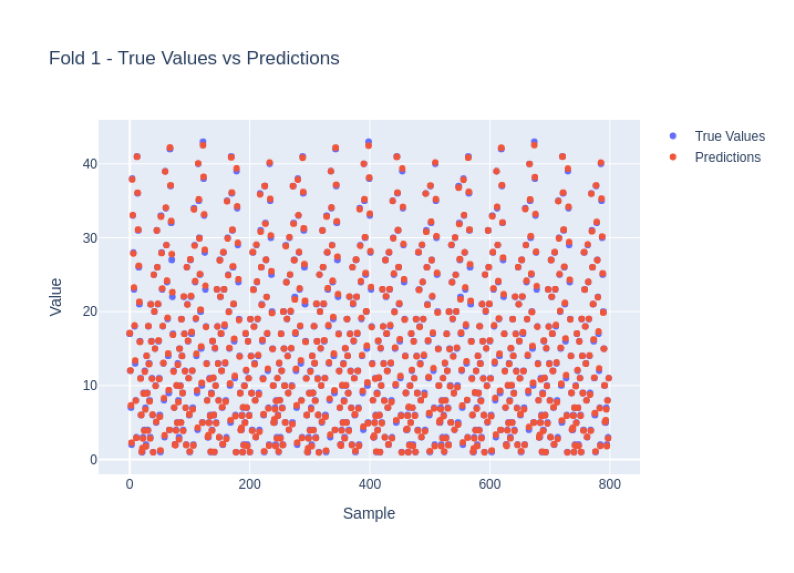

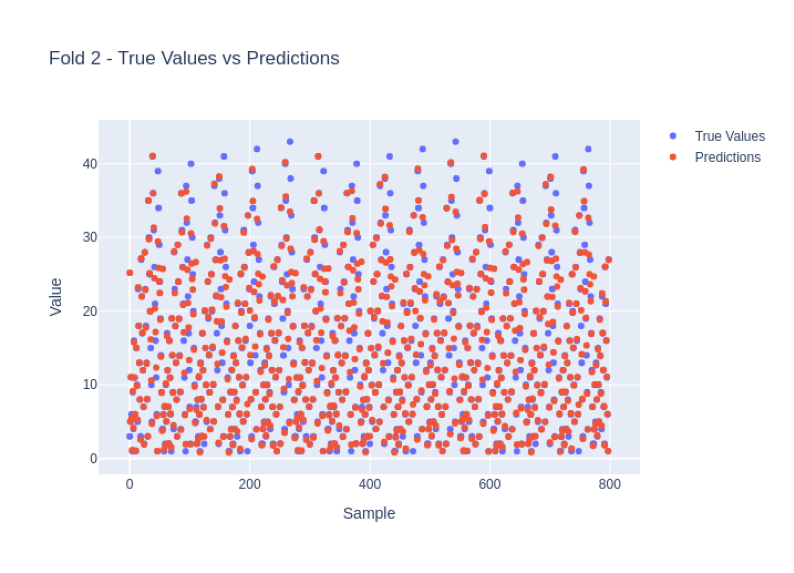

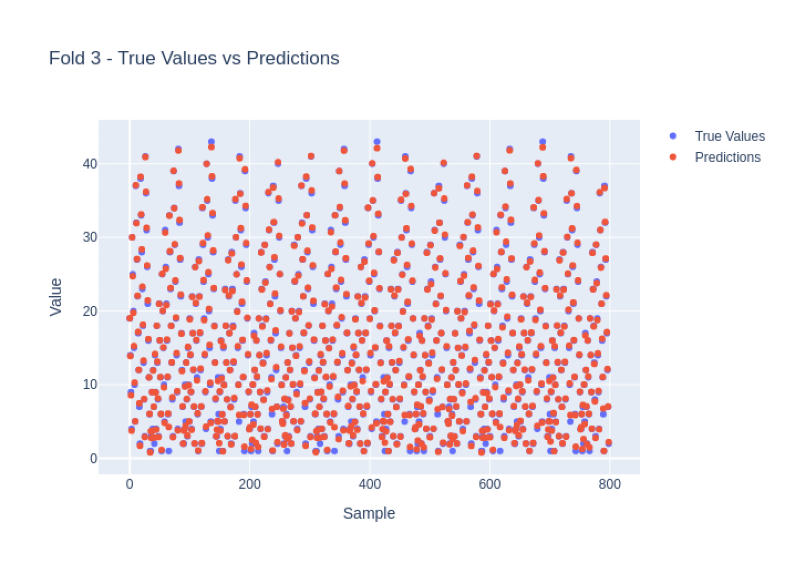

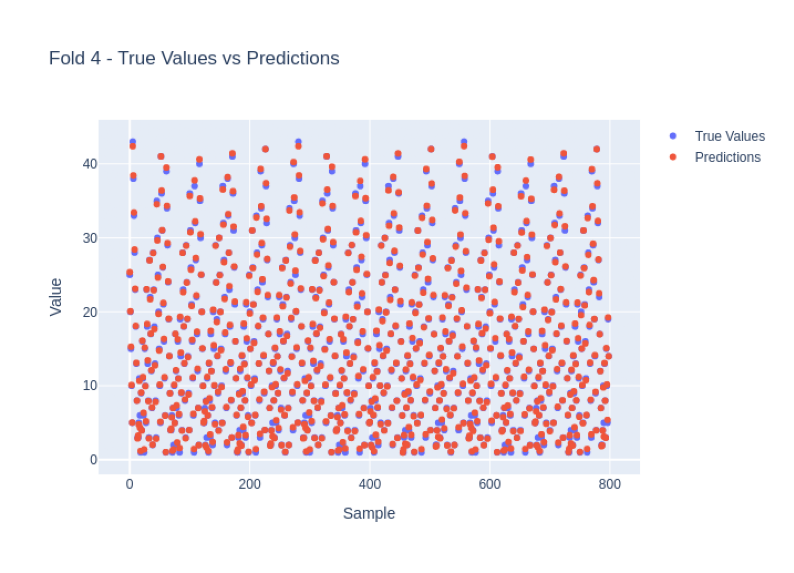

In [9]:
# from utils.utils import plot_preds_vs_truevalues
# from utils.train_pipeline import get_preds_best_config

# epochs_train_losses, epochs_val_losses, all_predictions, all_true_values = get_preds_best_config(study, pipeline, LSTMX1_X2BeforeLSTM, model_type, model_params_keys, num_epochs = num_epochs, seed=seed, X1=X1, X2=X2, y=y)

# # Plot the train and validation losses for each fold
# fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)
# for i in range(5):
#     axes[i].plot(epochs_train_losses[i], label="Train Loss")
#     axes[i].plot(epochs_val_losses[i], label="Validation Loss")
#     axes[i].set_title(f"Fold {i + 1}")
#     axes[i].set_xlabel("Epoch")
#     if i == 0:
#         axes[i].set_ylabel("Loss")
#     axes[i].legend()

# plt.tight_layout()
# plt.savefig(os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))
# plt.show()

# # Plot the predictions vs true values for each fold
# for fold in range(5):
#     plot_preds_vs_truevalues(np.ravel(all_true_values[fold]), np.ravel(all_predictions[fold]), fold, save_path=os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))

for fold in range(5):
    img = mpimg.imread(os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')  # Hide axes for a cleaner display
    plt.show()


Number of finished trials:  100
Best trial: 68
Best hyperparameters: {'learning_rate': 0.0006211356109998342, 'hidden_size': 64, 'num_layers': 2, 'batch_size': 16}
Validation Losses: [11.365, 11.252, 15.728, 13.283, 7.824]
Mean validation loss: 11.89
Test Losses: [10.754, 21.395, 22.089, 13.116, 15.508]
Mean test loss: 16.572
Mean test MAE: 2.514 std: 0.365
Mean test RMSE: 4.033 std: 0.555


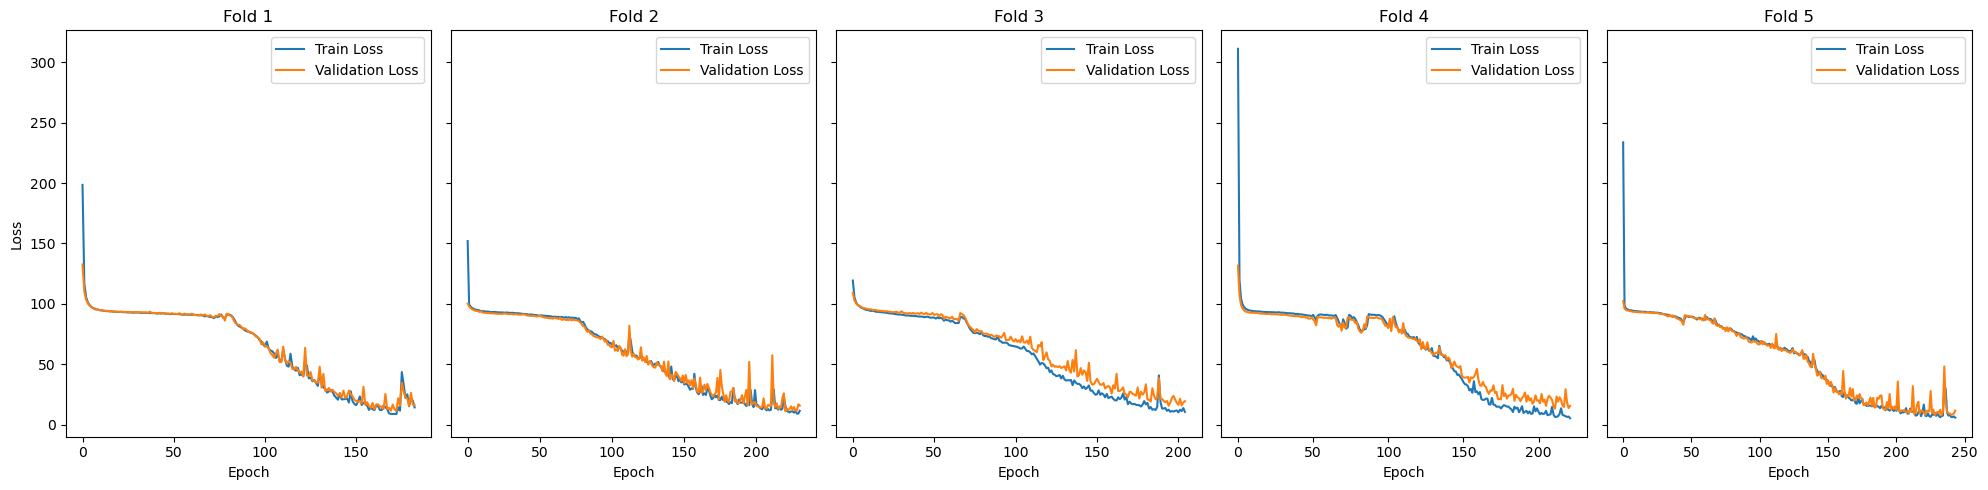

In [10]:
from models.lstm_pytorch import LSTMX1_X2AfterLSTM
from utils.train_pipeline import EarlyStopper, ModelTrainingPipeline, run_optuna_study

n_trials = 100
num_epochs = 500
model_type = "LSTM"
model_name = "LSTMX1_X2AfterLSTM"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3], 
        "kwargs": {"log": True} 
    },
    "hidden_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128, 256]] 
    },
    "num_layers": {
        "type": "categorical",
        "args": [[1, 2, 3]]  
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]] 
    }
}

model_params_keys = ["hidden_size", "num_layers"]

result_dir = os.path.join(results_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(result_dir, exist_ok=True)

#run_optuna_study(pipeline.run_cross_val, LSTMX1_X2AfterLSTM, model_type, suggestion_dict, model_params_keys, seed, X1, X2, y, result_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(result_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(study.trials_dataframe(), save_path=os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))



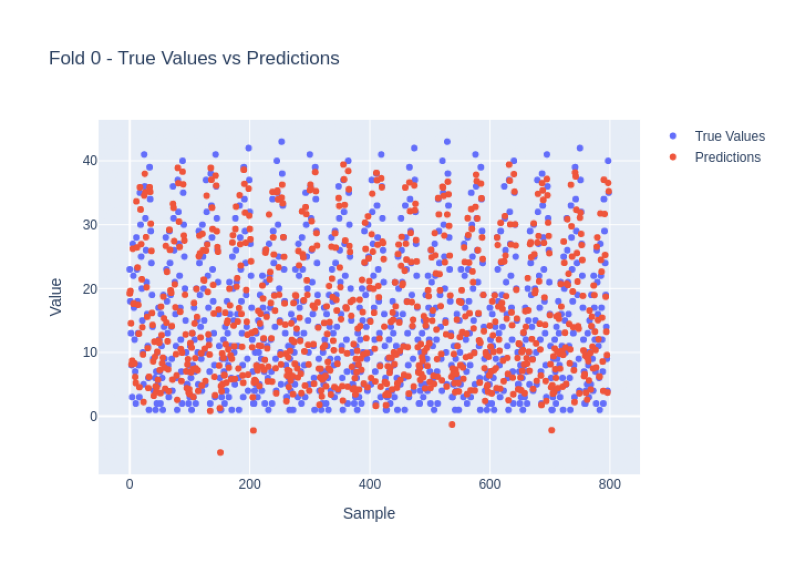

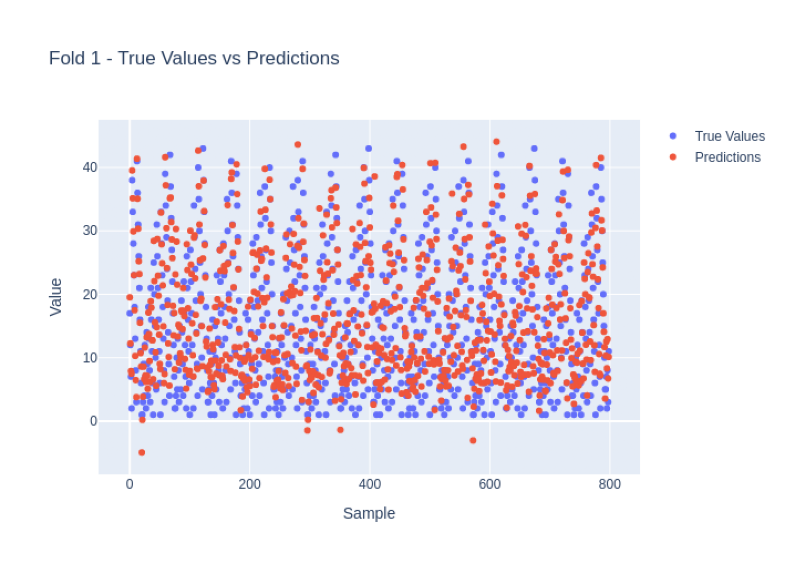

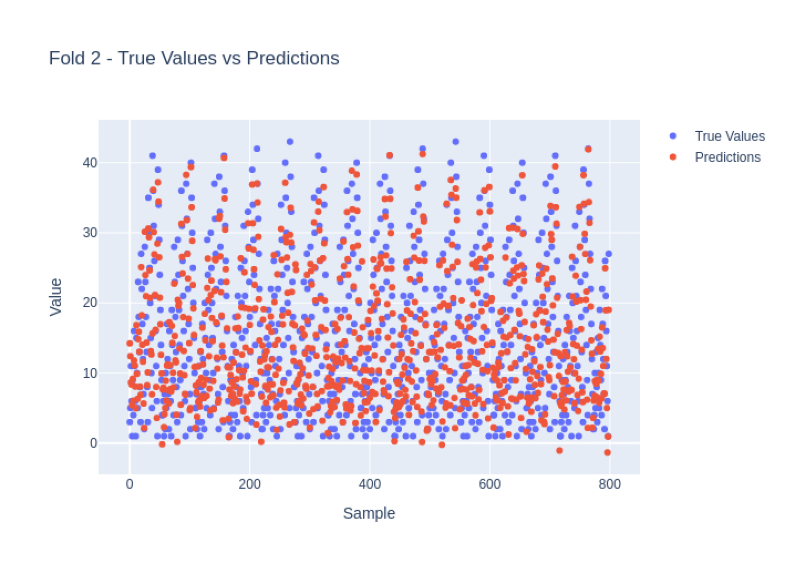

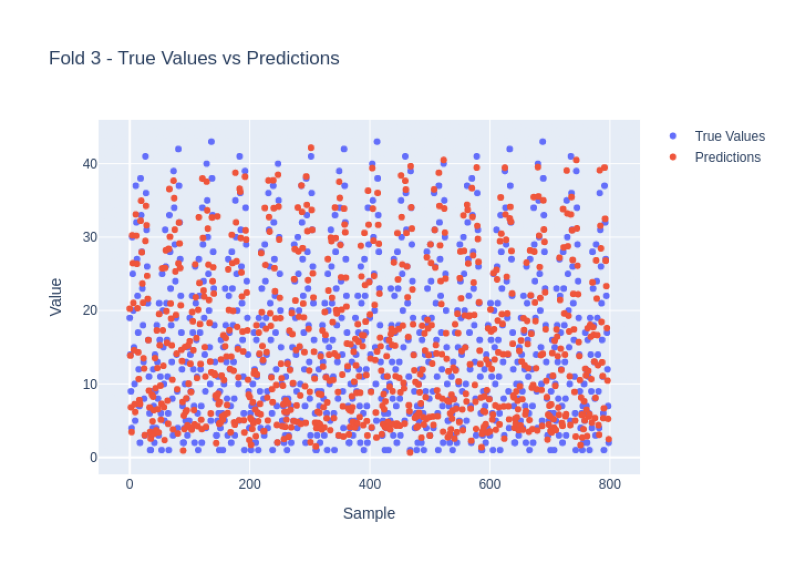

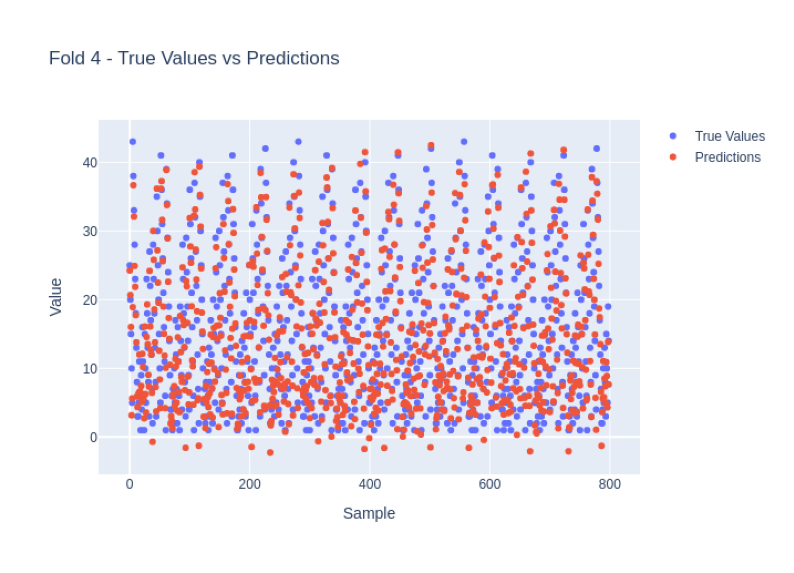

In [11]:
# from utils.utils import plot_preds_vs_truevalues
# from utils.train_pipeline import get_preds_best_config

# epochs_train_losses, epochs_val_losses, all_predictions, all_true_values = get_preds_best_config(study, pipeline, LSTMX1_X2AfterLSTM, model_type, model_params_keys, num_epochs = num_epochs, seed=seed, X1=X1, X2=X2, y=y)

# # Plot the train and validation losses for each fold
# fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)
# for i in range(5):
#     axes[i].plot(epochs_train_losses[i], label="Train Loss")
#     axes[i].plot(epochs_val_losses[i], label="Validation Loss")
#     axes[i].set_title(f"Fold {i + 1}")
#     axes[i].set_xlabel("Epoch")
#     if i == 0:
#         axes[i].set_ylabel("Loss")
#     axes[i].legend()

# plt.tight_layout()
# plt.savefig(os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))
# plt.show()

# # Plot the predictions vs true values for each fold
# for fold in range(5):
#     plot_preds_vs_truevalues(np.ravel(all_true_values[fold]), np.ravel(all_predictions[fold]), fold, save_path=os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))

#get the images predictions
for fold in range(5):
    img = mpimg.imread(os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')  # Hide axes for a cleaner display
    plt.show()



Number of finished trials:  100
Best trial: 67
Best hyperparameters: {'learning_rate': 0.0007051516616979146, 'hidden_size': 64, 'num_layers': 3, 'batch_size': 16}
Validation Losses: [5.635, 3.132, 6.567, 5.1, 9.008]
Mean validation loss: 5.888
Test Losses: [8.31, 6.91, 6.058, 7.678, 13.168]
Mean test loss: 8.425
Mean test MAE: 1.472 std: 0.193
Mean test RMSE: 2.874 std: 0.403


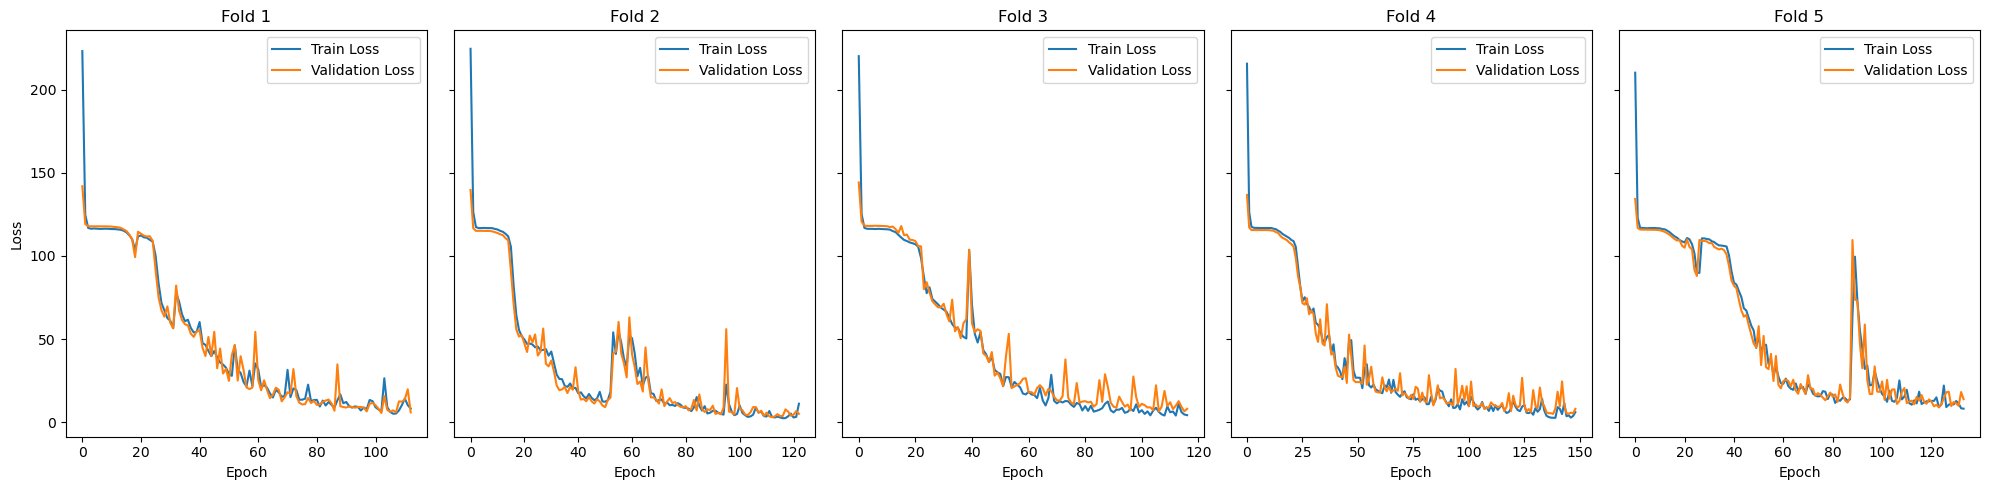

In [12]:
from models.lstm_pytorch import LSTMX1_X2Masking

n_trials = 100
num_epochs = 500
model_type = "LSTM"
model_name = "LSTMX1_X2Masking"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3], 
        "kwargs": {"log": True} 
    },
    "hidden_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128, 256]] 
    },
    "num_layers": {
        "type": "categorical",
        "args": [[1, 2, 3]]  
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]] 
    }
}

model_params_keys = ["hidden_size", "num_layers"]

#X1 shape is (num_samples, lookback_period)
masking_X1 = np.zeros((X1.shape[0], X1.shape[1])) 

for i, obs_motif_indexes in enumerate(X2):
    for j, idx in enumerate(obs_motif_indexes):
        masking_X1[i, idx.item():idx.item()+p] = 1

masking_X1 = torch.tensor(masking_X1, dtype=torch.float32)

result_dir = os.path.join(results_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(result_dir, exist_ok=True)

#run_optuna_study(pipeline.run_cross_val, LSTMX1_X2Masking, model_type, suggestion_dict, model_params_keys, seed, X1, masking_X1, y, result_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(result_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(study.trials_dataframe(), save_path=os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))



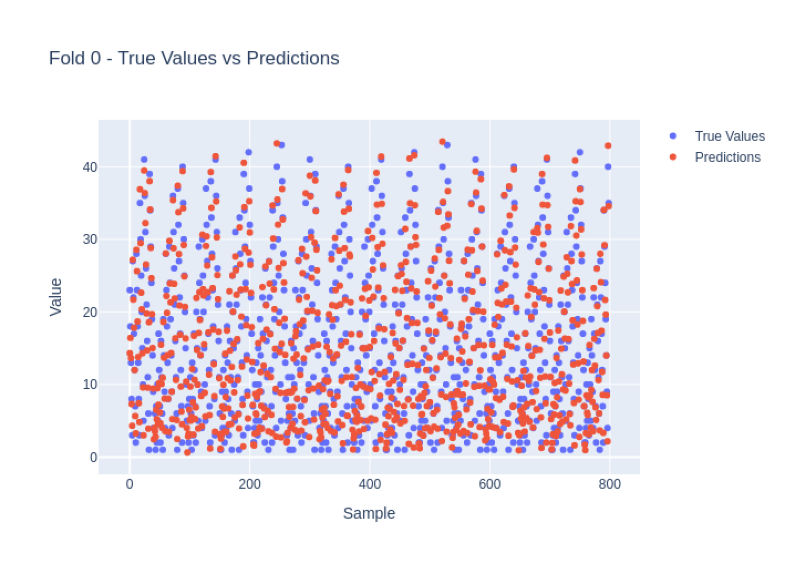

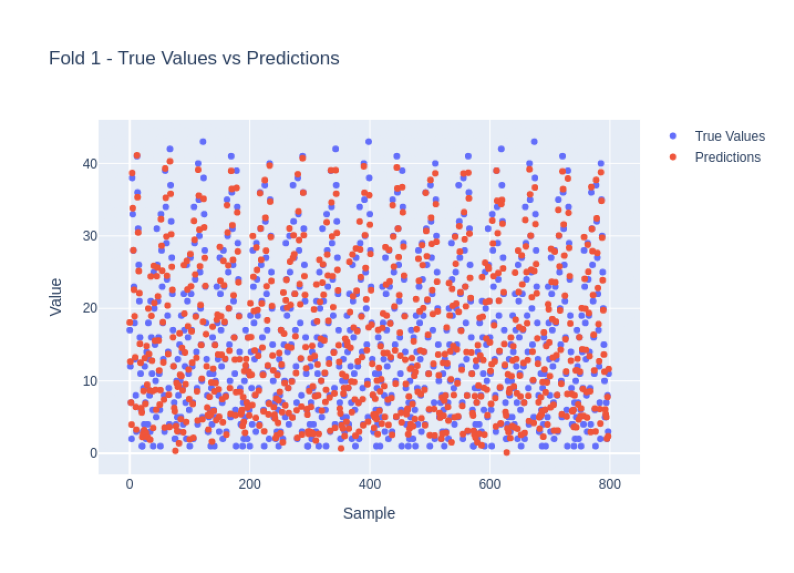

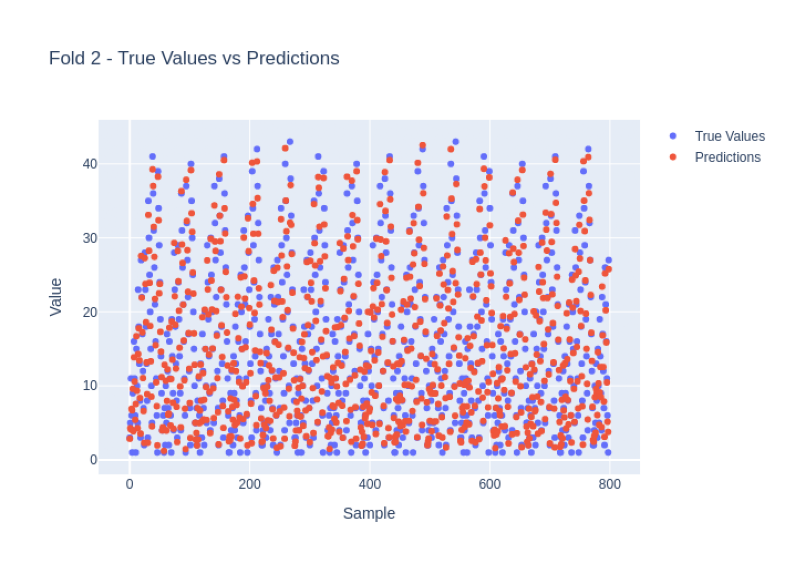

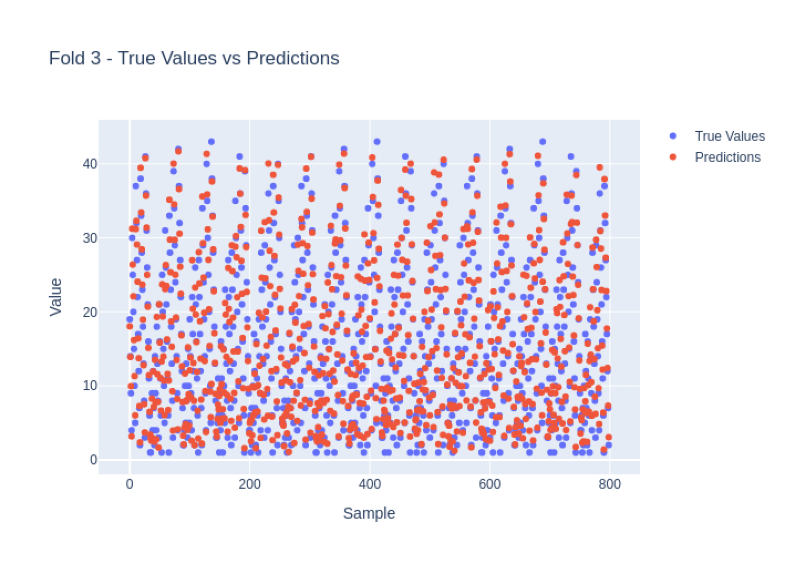

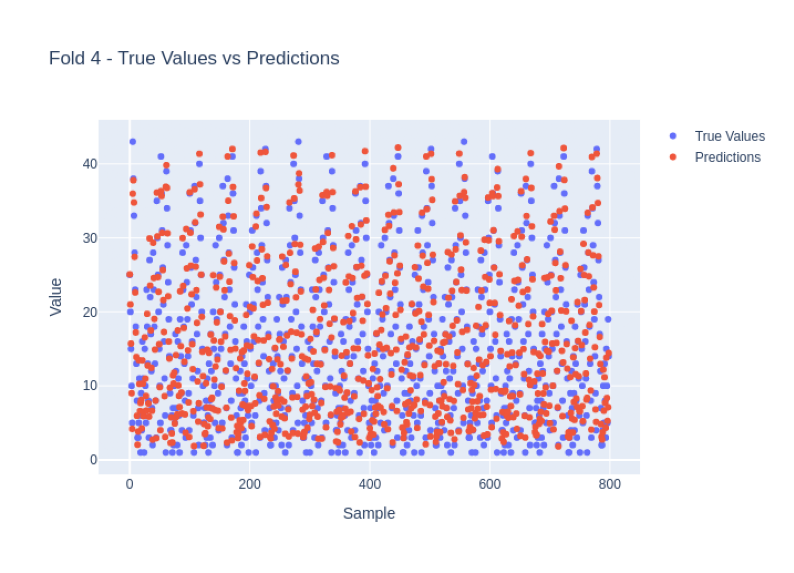

In [13]:
# from utils.utils import plot_preds_vs_truevalues
# from utils.train_pipeline import get_preds_best_config

# epochs_train_losses, epochs_val_losses, all_predictions, all_true_values = get_preds_best_config(study, pipeline, LSTMX1_X2Masking, model_type, model_params_keys, num_epochs = num_epochs, seed=seed, X1=X1, X2=masking_X1, y=y)

# # Plot the train and validation losses for each fold
# fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)
# for i in range(5):
#     axes[i].plot(epochs_train_losses[i], label="Train Loss")
#     axes[i].plot(epochs_val_losses[i], label="Validation Loss")
#     axes[i].set_title(f"Fold {i + 1}")
#     axes[i].set_xlabel("Epoch")
#     if i == 0:
#         axes[i].set_ylabel("Loss")
#     axes[i].legend()

# plt.tight_layout()
# plt.savefig(os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))
# plt.show()

# # Plot the predictions vs true values for each fold
# for fold in range(5):
#     plot_preds_vs_truevalues(np.ravel(all_true_values[fold]), np.ravel(all_predictions[fold]), fold, save_path=os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))


for fold in range(5):
    img = mpimg.imread(os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')  # Hide axes for a cleaner display
    plt.show()


Number of finished trials:  100
Best trial: 81
Best hyperparameters: {'learning_rate': 0.00010510122450513728, 'hidden_size': 128, 'num_layers': 3, 'batch_size': 16}
Validation Losses: [10.797, 7.048, 15.628, 33.395, 111.372]
Mean validation loss: 35.648
Test Losses: [13.794, 8.328, 18.749, 115.102, 114.132]
Mean test loss: 54.021
Mean test MAE: 4.836 std: 3.26
Mean test RMSE: 6.468 std: 3.49


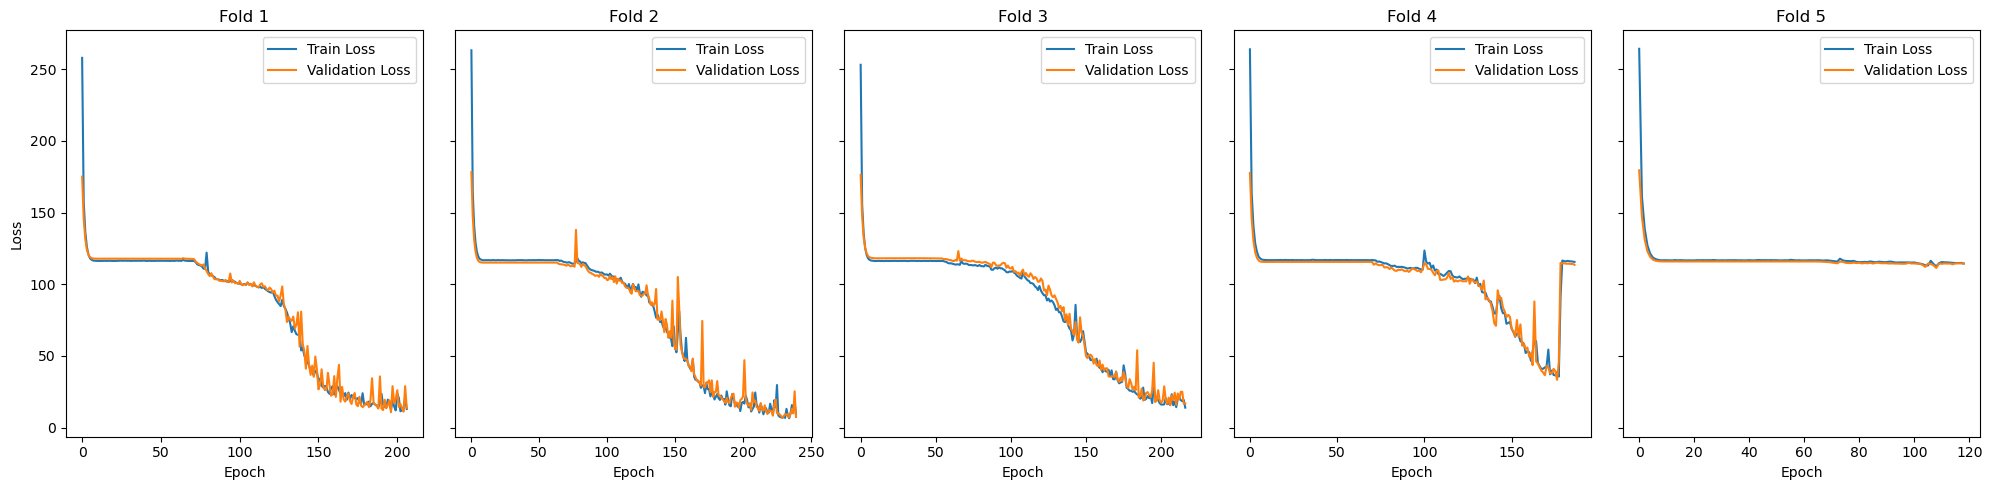

In [14]:
from models.lstm_pytorch import LSTMAttentionX1

n_trials = 100
num_epochs = 500
model_type = "LSTM"
model_name = "LSTMAttentionX1"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3], 
        "kwargs": {"log": True} 
    },
    "hidden_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128, 256]] 
    },
    "num_layers": {
        "type": "categorical",
        "args": [[1, 2, 3]]  
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]] 
    }
}

model_params_keys = ["hidden_size", "num_layers"]

result_dir = os.path.join(results_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(result_dir, exist_ok=True)

#run_optuna_study(pipeline.run_cross_val, LSTMAttentionX1, model_type, suggestion_dict, model_params_keys, seed, X1, None, y, result_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(result_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(study.trials_dataframe(), save_path=os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))

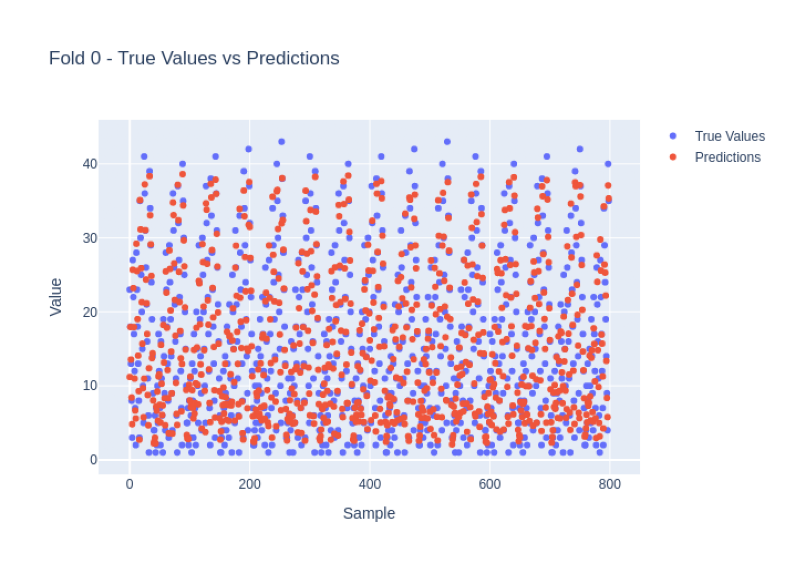

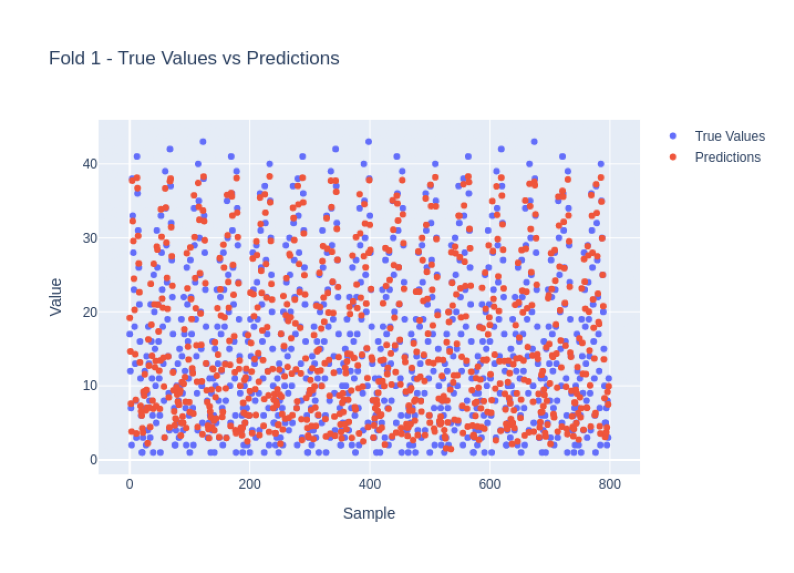

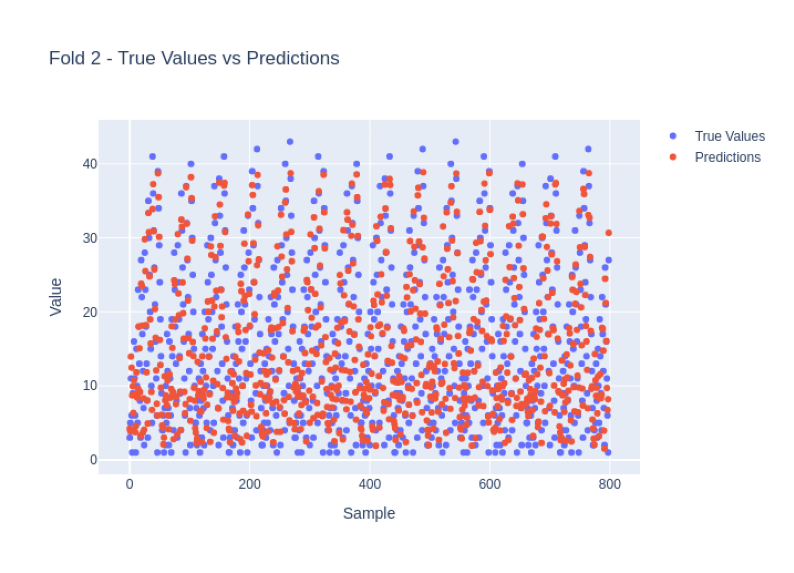

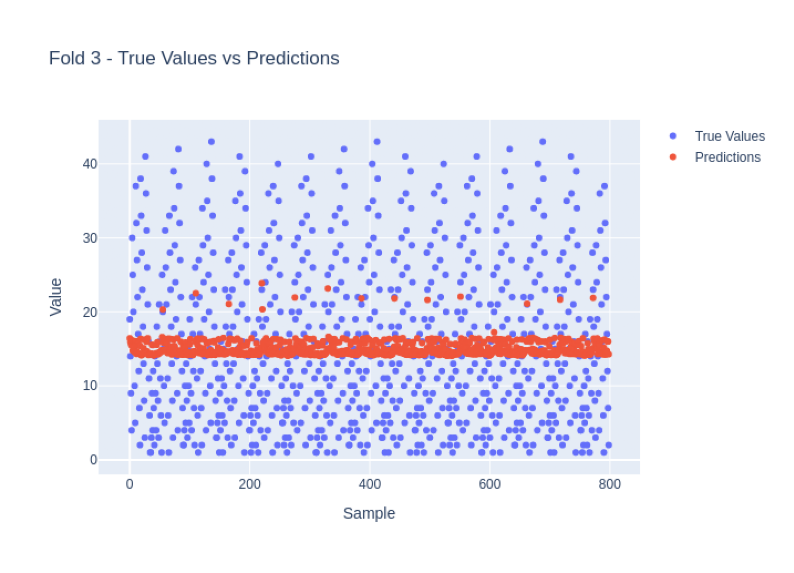

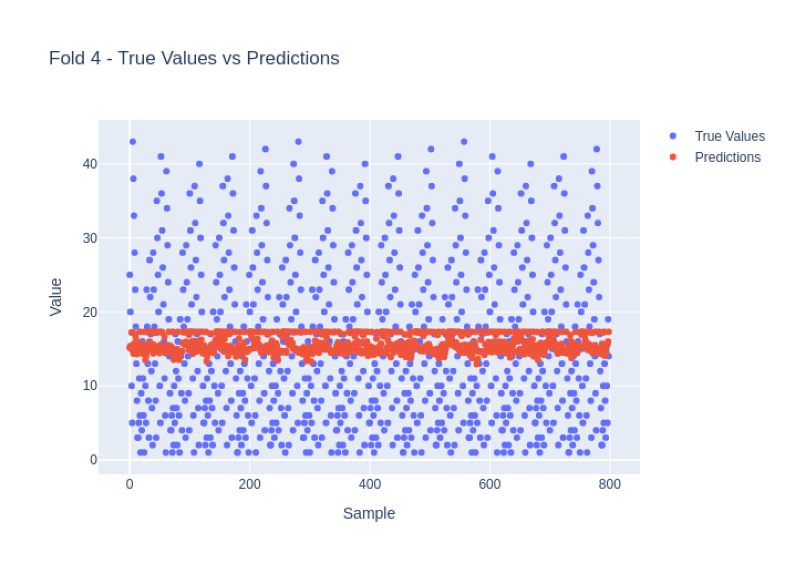

In [15]:
# from utils.utils import plot_preds_vs_truevalues
# from utils.train_pipeline import get_preds_best_config

# epochs_train_losses, epochs_val_losses, all_predictions, all_true_values = get_preds_best_config(study, pipeline, LSTMAttentionX1, model_type, model_params_keys, num_epochs = num_epochs, seed=seed, X1=X1, X2=None, y=y)

# # Plot the train and validation losses for each fold
# fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)
# for i in range(5):
#     axes[i].plot(epochs_train_losses[i], label="Train Loss")
#     axes[i].plot(epochs_val_losses[i], label="Validation Loss")
#     axes[i].set_title(f"Fold {i + 1}")
#     axes[i].set_xlabel("Epoch")
#     if i == 0:
#         axes[i].set_ylabel("Loss")
#     axes[i].legend()

# plt.tight_layout()
# plt.savefig(os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))
# plt.show()

# # Plot the predictions vs true values for each fold
# for fold in range(5):
#     plot_preds_vs_truevalues(np.ravel(all_true_values[fold]), np.ravel(all_predictions[fold]), fold, save_path=os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))


for fold in range(5):
    img = mpimg.imread(os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')  # Hide axes for a cleaner display
    plt.show()